## Get data

In [1]:
!pip install scikit-multilearn
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.4 MB/s 
Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.1 which is incompatible.


In [2]:
from google.colab import drive
from psutil import virtual_memory

drive.mount('/content/gdrive/', force_remount=True)
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Mounted at /content/gdrive/
Your runtime has 54.8 gigabytes of available RAM



In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


import tensorflow as tf
from tensorflow.python.keras import layers
from skmultilearn.adapt import MLkNN

import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir("gdrive/MyDrive/Dissertation/ukdale")

In [5]:
data = pd.read_csv('processed_data/125_tsfresh_labeled.csv', index_col=[0])
labels = data['3'].str.split(', ')
print(data.shape)

(931117, 792)


In [6]:
house_1_features = data.loc[:568302,~data.columns.isin(['1','2','3'])]
house_1_labels = labels.loc[:568302]
print(f'House 1 features: {house_1_features.shape}')
print(f'House 1 labels: {house_1_labels.shape}')

house_2_features = data.loc[568303:741073,~data.columns.isin(['1','2','3'])]
house_2_labels = labels.loc[568303:741073]
print(f'House 2 features: {house_2_features.shape}')
print(f'House 2 labels: {house_2_labels.shape}')

house_5_features = data.loc[741074:931116,~data.columns.isin(['1','2','3'])]
house_5_labels = labels.loc[741074:931116]
print(f'House 5 features: {house_5_features.shape}')
print(f'House 5 labels: {house_5_labels.shape}')

House 1 features: (568303, 789)
House 1 labels: (568303,)
House 2 features: (172771, 789)
House 2 labels: (172771,)
House 5 features: (190043, 789)
House 5 labels: (190043,)


In [7]:
h1h5 = pd.concat([house_1_features, house_5_features], ignore_index=True)
h1h5['labels'] = pd.concat([house_1_labels, house_5_labels], ignore_index=True)
h1h5 = h1h5.sample(frac=1, random_state=1).reset_index(drop=True)
h1h5.head()

,aggregate__variance_larger_than_standard_deviation,aggregate__has_duplicate_max,aggregate__has_duplicate_min,aggregate__has_duplicate,aggregate__sum_values,aggregate__abs_energy,aggregate__mean_abs_change,aggregate__mean_change,aggregate__mean_second_derivative_central,aggregate__median,...,aggregate__permutation_entropy__dimension_7__tau_1,aggregate__query_similarity_count__query_None__threshold_0.0,"aggregate__matrix_profile__feature_""min""__threshold_0.98","aggregate__matrix_profile__feature_""max""__threshold_0.98","aggregate__matrix_profile__feature_""mean""__threshold_0.98","aggregate__matrix_profile__feature_""median""__threshold_0.98","aggregate__matrix_profile__feature_""25""__threshold_0.98","aggregate__matrix_profile__feature_""75""__threshold_0.98",aggregate__mean_n_absolute_max__number_of_maxima_7,labels
0,0.0,0.0,1.0,1.0,1559.0,243051.0,0.666667,0.000000,0.000000,156.0,...,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.142857,[all_off]
1,1.0,1.0,0.0,1.0,2512.0,631028.0,1.444444,-0.111111,-0.187500,251.0,...,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251.714286,[fridge]
2,1.0,1.0,1.0,1.0,1441.0,230733.0,1.500000,0.000000,-0.214286,160.0,...,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.428571,[all_off]
3,1.0,0.0,0.0,0.0,6956.0,5858720.0,326.888889,-0.444444,0.562500,904.0,...,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,902.428571,[washing_machine]
4,1.0,0.0,1.0,1.0,3323.0,1104253.0,1.555556,-0.222222,0.062500,332.0,...,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,332.857143,[all_off]


In [8]:
# Get features and labels from the train and test dataset
Xtr = h1h5.loc[:,~h1h5.columns.isin(['labels'])]
ytr = h1h5['labels']
Xt = house_2_features.copy()
yt = house_2_labels.copy()

for df, name in zip([Xtr, ytr, Xt, yt],['Train features', 'Train labels', 'Test features', 'Test labels']):
    print(f'{name} shape : {df.shape}')

Train features shape : (758346, 789)
Train labels shape : (758346,)
Test features shape : (172771, 789)
Test labels shape : (172771,)


## Feature Selection

### FInd and drop correlated features

In [9]:
def correlation(data, threshold):
    corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (corr_mat.iloc[i,j]) > threshold:
                col = corr_mat.columns[i]
                corr.add(col)
    return corr

# Find correlated columns in train data
cols = correlation(Xtr, 0.85)
print(len(set(cols)))

# Remove correlated columns from train and test data
Xtr = Xtr.drop(cols, axis=1)
Xt = Xt.drop(cols, axis=1)

106


### Scaling and encoding features and labels

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_test = scaler.transform(Xt)

encoding = MultiLabelBinarizer()
y_train = encoding.fit_transform(ytr)
y_test = encoding.transform(yt)
print(encoding.classes_)

['all_off' 'dishwasher' 'fridge' 'washing_machine']


## Performance metrics

In [21]:
def model_scores(ypred, ytest):
    print(f'Accuracy : {accuracy_score(ytest, ypred)}')
    print(f'Mean absolute error : {mean_absolute_error(ytest, ypred)}')
    print(classification_report(ytest, ypred))

    cm = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))
    plt.figure(figsize = (10,7))

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', ax = ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['OFF states', 'Dishwasher', 'Fridge', 'Washing machine']); ax.yaxis.set_ticklabels(['OFF states', 'Dishwasher', 'Fridge', 'Washing machine']);

## Learning model

### Artificial Neural Network

In [12]:
# define model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(128, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [13]:
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
model = get_model(n_inputs, n_outputs)
history = model.fit(X_train, y_train, batch_size=128, validation_split = 0.2, epochs=20)

Epoch 1/20
4740/4740 [==============================] - 18s 4ms/step - loss: 0.2984 - accuracy: 0.6634 - val_loss: 0.2824 - val_accuracy: 0.6779
Epoch 2/20
4740/4740 [==============================] - 17s 3ms/step - loss: 0.2781 - accuracy: 0.6802 - val_loss: 0.2746 - val_accuracy: 0.6835
Epoch 3/20
4740/4740 [==============================] - 17s 4ms/step - loss: 0.2721 - accuracy: 0.6854 - val_loss: 0.2717 - val_accuracy: 0.6858
Epoch 4/20
4740/4740 [==============================] - 16s 3ms/step - loss: 0.2691 - accuracy: 0.6885 - val_loss: 0.2692 - val_accuracy: 0.6871
Epoch 5/20
4740/4740 [==============================] - 17s 4ms/step - loss: 0.2667 - accuracy: 0.6903 - val_loss: 0.2691 - val_accuracy: 0.6879
Epoch 6/20
4740/4740 [==============================] - 16s 3ms/step - loss: 0.2650 - accuracy: 0.6915 - val_loss: 0.2697 - val_accuracy: 0.6878
Epoch 7/20
4740/4740 [==============================] - 16s 3ms/step - loss: 0.2636 - accuracy: 0.6933 - val_loss: 0.2676 - val_ac

Accuracy : 0.034403921954494675
Mean absolute error : 0.6019355100103605
              precision    recall  f1-score   support

           0       0.25      0.00      0.00    123742
           1       0.40      0.85      0.55      3005
           2       0.12      0.96      0.21     20474
           3       0.14      0.97      0.24     23080

   micro avg       0.13      0.26      0.18    170301
   macro avg       0.23      0.70      0.25    170301
weighted avg       0.22      0.26      0.07    170301
 samples avg       0.14      0.23      0.17    170301



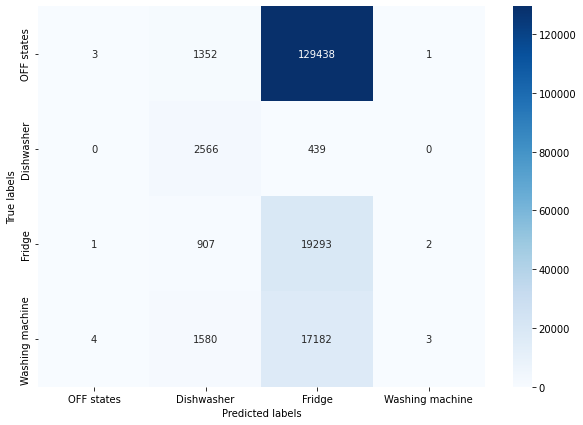

In [22]:
yhat = model.predict(X_test)
ypred = yhat.round()
model_scores(y_test, ypred)

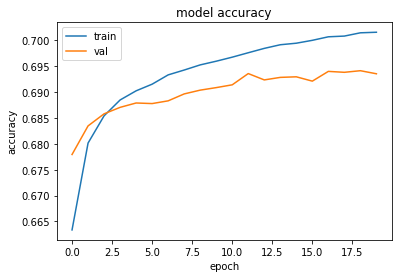

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

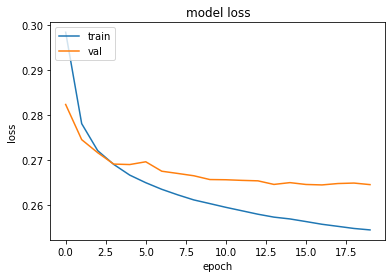

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MLkNN

In [25]:
classifier = MLkNN(k=3)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

Accuracy : 0.07902367874238153
Mean absolute error : 0.4537885409009613
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     70386
           1       0.26      0.74      0.38      2239
           2       0.37      0.97      0.53     63613
           3       0.20      0.94      0.34     35035

   micro avg       0.29      0.56      0.38    171273
   macro avg       0.21      0.66      0.31    171273
weighted avg       0.18      0.56      0.27    171273
 samples avg       0.29      0.49      0.36    171273



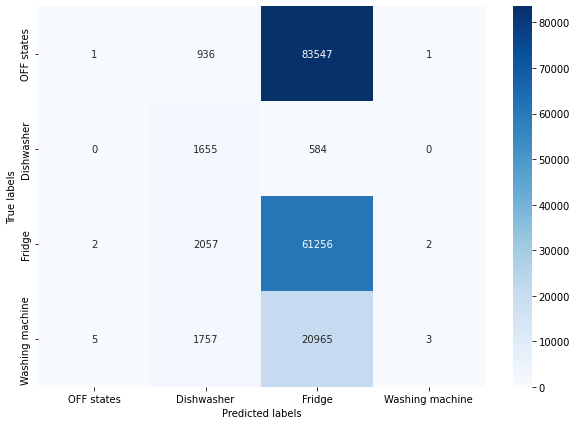

In [26]:
ypred = predictions.toarray()
model_scores(y_test, ypred)

### RakEl

In [19]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.ensemble import RandomForestClassifier

classifier = RakelD(
    base_classifier=RandomForestClassifier(),
    base_classifier_require_dense=[True, True],
    labelset_size=4
)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

Accuracy : 0.05246250817556187
Mean absolute error : 0.4496920779528972
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     73838
           1       0.22      0.82      0.35      1731
           2       0.12      0.92      0.21     21886
           3       0.50      0.97      0.66     83249

   micro avg       0.31      0.57      0.40    180704
   macro avg       0.21      0.68      0.31    180704
weighted avg       0.25      0.57      0.33    180704
 samples avg       0.30      0.55      0.39    180704



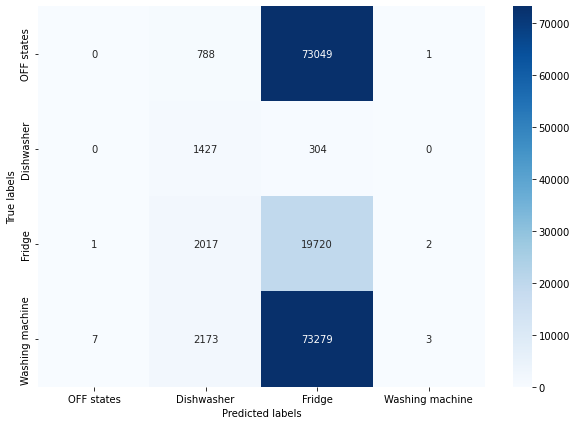

In [24]:
ypred = predictions.toarray()
model_scores(y_test, ypred)